# Named Entity Recognition with the Born Classifier

In [47]:
from datasets import load_dataset
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt 

import pandas as pd
import numpy as np

from utils import expand_conll_dataframe

from bornrule import BornClassifier

## Data Loading and Processing

In [2]:
dataset = load_dataset("eriktks/conll2003", trust_remote_code=True)

In [3]:
dataset['train'].features

{'id': Value(dtype='string', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'pos_tags': Sequence(feature=ClassLabel(names=['"', "''", '#', '$', '(', ')', ',', '.', ':', '``', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'NN|SYM', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB'], id=None), length=-1, id=None),
 'chunk_tags': Sequence(feature=ClassLabel(names=['O', 'B-ADJP', 'I-ADJP', 'B-ADVP', 'I-ADVP', 'B-CONJP', 'I-CONJP', 'B-INTJ', 'I-INTJ', 'B-LST', 'I-LST', 'B-NP', 'I-NP', 'B-PP', 'I-PP', 'B-PRT', 'I-PRT', 'B-SBAR', 'I-SBAR', 'B-UCP', 'I-UCP', 'B-VP', 'I-VP'], id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], id=None), length=-1, id=None)}

In [4]:
train, valid, test = pd.DataFrame(dataset['train']).set_index('id'), pd.DataFrame(dataset['validation']).set_index('id'), pd.DataFrame(dataset['test']).set_index('id')

In [5]:
train.head(10)

,tokens,pos_tags,chunk_tags,ner_tags
id,,,,
0,"[EU, rejects, German, call, to, boycott, Briti...","[22, 42, 16, 21, 35, 37, 16, 21, 7]","[11, 21, 11, 12, 21, 22, 11, 12, 0]","[3, 0, 7, 0, 0, 0, 7, 0, 0]"
1,"[Peter, Blackburn]","[22, 22]","[11, 12]","[1, 2]"
2,"[BRUSSELS, 1996-08-22]","[22, 11]","[11, 12]","[5, 0]"
3,"[The, European, Commission, said, on, Thursday...","[12, 22, 22, 38, 15, 22, 28, 38, 15, 16, 21, 3...","[11, 12, 12, 21, 13, 11, 11, 21, 13, 11, 12, 1...","[0, 3, 4, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, ..."
4,"[Germany, 's, representative, to, the, Europea...","[22, 27, 21, 35, 12, 22, 22, 27, 16, 21, 22, 2...","[11, 11, 12, 13, 11, 12, 12, 11, 12, 12, 12, 1...","[5, 0, 0, 0, 0, 3, 4, 0, 0, 0, 1, 2, 0, 0, 0, ..."
5,"["", We, do, n't, support, any, such, recommend...","[0, 28, 41, 30, 37, 12, 16, 21, 15, 28, 41, 30...","[0, 11, 21, 22, 22, 11, 12, 12, 17, 11, 21, 22...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,"[He, said, further, scientific, study, was, re...","[28, 38, 16, 16, 21, 38, 40, 10, 15, 28, 38, 4...","[11, 21, 11, 12, 12, 21, 22, 0, 17, 11, 21, 22...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,"[He, said, a, proposal, last, month, by, EU, F...","[28, 38, 12, 21, 16, 21, 15, 22, 22, 22, 22, 2...","[11, 21, 11, 12, 11, 12, 13, 11, 12, 12, 12, 1...","[0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 2, 0, 0, 0, ..."
8,"[Fischler, proposed, EU-wide, measures, after,...","[17, 40, 22, 42, 15, 24, 15, 22, 10, 22, 43, 1...","[11, 12, 12, 21, 13, 11, 13, 11, 12, 12, 11, 1...","[1, 0, 7, 0, 0, 0, 0, 5, 0, 5, 0, 0, 0, 0, 0, ..."


In [6]:
train.isnull().sum(), valid.isnull().sum(), test.isnull().sum()

(tokens        0
 pos_tags      0
 chunk_tags    0
 ner_tags      0
 dtype: int64,
 tokens        0
 pos_tags      0
 chunk_tags    0
 ner_tags      0
 dtype: int64,
 tokens        0
 pos_tags      0
 chunk_tags    0
 ner_tags      0
 dtype: int64)

We'll transform the DataFrame in a more ameanable format.

In [7]:
train_exp, valid_exp, test_exp = expand_conll_dataframe(train), expand_conll_dataframe(valid), expand_conll_dataframe(test)

In [8]:
# it's a good idea to check, just in case...
train_exp.isnull().sum(), valid_exp.isnull().sum(), test_exp.isnull().sum()

(sentence_id    0
 token          0
 pos_tag        0
 chunk_tag      0
 ner_tag        0
 dtype: int64,
 sentence_id    0
 token          0
 pos_tag        0
 chunk_tag      0
 ner_tag        0
 dtype: int64,
 sentence_id    0
 token          0
 pos_tag        0
 chunk_tag      0
 ner_tag        0
 dtype: int64)

In [9]:
train_exp.head(15)

,sentence_id,token,pos_tag,chunk_tag,ner_tag
0,0,EU,22,11,3
1,0,rejects,42,21,0
2,0,German,16,11,7
3,0,call,21,12,0
4,0,to,35,21,0
5,0,boycott,37,22,0
6,0,British,16,11,7
7,0,lamb,21,12,0
8,0,.,7,0,0
9,1,Peter,22,11,1


In [10]:
tag_mappings = {i: name for i, name in enumerate(dataset['train'].features['ner_tags'].feature.names)}

named_train = train_exp['ner_tag'].map(tag_mappings)
# should we be surprised by the number of outside (O) tags? not really: all non-entity words are marked as such, and there are many more of those!
named_train.value_counts().reset_index(name='counts')

,ner_tag,counts
0,O,169578
1,B-LOC,7140
2,B-PER,6600
3,B-ORG,6321
4,I-PER,4528
5,I-ORG,3704
6,B-MISC,3438
7,I-LOC,1157
8,I-MISC,1155


In [11]:
y_train = train_exp.ner_tag.to_list()
X_train = train_exp.drop('ner_tag', axis=1)

y_val = valid_exp.ner_tag.to_list()
X_val = valid_exp.drop('ner_tag', axis=1)

y_test = test_exp.ner_tag.to_list()
X_test = test_exp.drop('ner_tag', axis=1)

In [12]:
dict_vec = DictVectorizer()
X_train = dict_vec.fit_transform(X_train.to_dict('records'))
X_val = dict_vec.transform(X_val.to_dict('records'))
X_test = dict_vec.transform(X_test.to_dict('records'))

## Classifying with Born

In [13]:
born = BornClassifier()

In [14]:
born.fit(X_train, y_train)

BornClassifier()

In [46]:
y_pred = born.predict(X_test)
# we need to eliminate the O tag (the 0th label), or we'll get an over-estimate (because the O tags heavily outnumber the rest)
print(classification_report(y_true=y_test, y_pred=y_pred, labels=np.unique(y_train)))

              precision    recall  f1-score   support

           0       0.98      0.84      0.90     38323
           1       0.64      0.42      0.51      1617
           2       0.24      0.31      0.27      1156
           3       0.50      0.51      0.51      1661
           4       0.19      0.49      0.27       835
           5       0.44      0.76      0.56      1668
           6       0.15      0.61      0.24       257
           7       0.27      0.63      0.38       702
           8       0.10      0.69      0.17       216

    accuracy                           0.78     46435
   macro avg       0.39      0.58      0.42     46435
weighted avg       0.88      0.78      0.82     46435



In [16]:
cm = confusion_matrix(y_test, y_pred, labels=range(len(dataset['train'].features['ner_tags'].feature.names)))

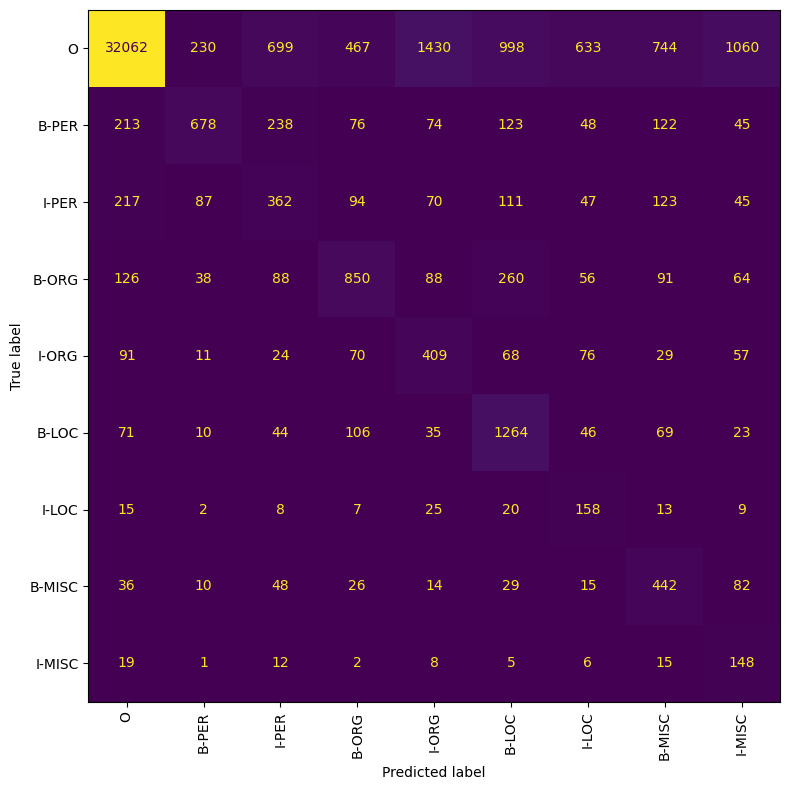

In [17]:
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset['train'].features['ner_tags'].feature.names)
disp.plot(ax=ax, cmap='viridis', colorbar=False)
ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

As one would expect, the outside (O) tag dominates the confusiom matrix (and most entities are confused with it, as we can see fromt the first row).

## Explanation

In [29]:
features = dict_vec.get_feature_names_out()
columns = dataset['train'].features['ner_tags'].feature.names
explain_df = pd.DataFrame(born.explain().toarray(), index=features, columns=columns)

In [40]:
explain_df.loc['token=EU'].sort_values(ascending=False)

B-ORG     0.010408
O         0.000000
B-PER     0.000000
I-PER     0.000000
I-ORG     0.000000
B-LOC     0.000000
I-LOC     0.000000
B-MISC    0.000000
I-MISC    0.000000
Name: token=EU, dtype: float64

In [44]:
explain_df['B-ORG'].sort_values(ascending=False).head(15)

token=Reuters      0.018880
token=U.N.         0.013338
token=Ajax         0.012341
token=PSV          0.011206
token=PUK          0.010530
token=EU           0.010408
token=OSCE         0.010346
token=NATO         0.009966
token=Honda        0.009508
token=Interfax     0.009126
token=Nice         0.009125
token=Borussia     0.009006
token=Fortuna      0.008985
token=Marseille    0.008732
token=KDP          0.008723
Name: B-ORG, dtype: float64

In [ ]:
# TODO compare with other classifiers from sklearn